# Matrix Factorization encodings visualizations
We take the encodings produced with Matrix Factorization for users and movies and project them into two dimensional space using PCS, TSNE and UMAP. We label the points representing the users and movies according to metadata characteristics such as a movie's genre and a persons's age in the hope of noticing relevant clusters consistant to those categorizations.

Since the number of samples is relatively large for visualization, same for the number of categories of specific attributes, for each visualization we will do some filtering of the data to make the plots more clear.

In [1]:
import numpy as np

movie_encodings = np.load('movie_encodings_MF_1.npy')
user_encodings = np.load('user_encodings_MF_1.npy')

In [2]:
import pandas as pd

movies = pd.read_csv('https://storage.googleapis.com/lu_ds/adm/movies.dat', sep="::", header=0, names=['MovieID', 'Title', 'Genre'], engine='python', encoding='ISO-8859-1')
movies['Genre'] = [s.split('|')[0] for s in movies['Genre']]    # for simplicity for now we keep only the first genre
movies.head(2)

users = pd.read_csv('https://storage.googleapis.com/lu_ds/adm/users.dat', sep="::", header=0, names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], engine='python')
users.head(2)

,UserID,Gender,Age,Occupation,ZipCode
0,2,M,56,16,70072
1,3,M,25,15,55117


In [34]:
import random as rn
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

def get_or_none(getter):
    try:
        return getter()
    except KeyError:
        return 'Unknown'

def choose_some(labels, n):
    choices = rn.sample(list(set(labels)), n)
    return np.array([label if label in choices else None for label in labels])

def choose_subset(labels, subset):
    return np.array([label if label in subset else None for label in labels])

def labeled_scatter_plot(features, labels, name, label_order=None, ax=None, label_renaming=None):
    unique_labels = set(labels)
    
    if label_order is None:
        label_order = unique_labels

    if label_renaming is None:
        label_renaming_func = lambda x: x
    else:
        label_renaming_func = lambda x: label_renaming[x]
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    for label, color in zip(label_order, colors):
        if label is None:
            continue
        indices = labels == label
        ax.scatter(features[indices, 0], features[indices, 1], label=label_renaming_func(label), color=color)

    ax.set_title(name)
    ax.legend(loc='upper right')

def project_and_plot(encodings, labels, elements_name=None, label_type_name=None, title=None, **kwargs):
    fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
    if title:
        fig.suptitle(title, fontsize=22, va='bottom')
    def get_title(model_name):
        if not elements_name:
            return model_name
        if not label_type_name:
            return f'{model_name} of {elements_name}'
        return f'{model_name} of {elements_name} labeled by {label_type_name}'
    labeled_scatter_plot(PCA(n_components=2).fit_transform(encodings), labels, get_title('PCA'), ax=axs[0], **kwargs)
    labeled_scatter_plot(TSNE(n_components=2).fit_transform(encodings), labels, get_title('TSNE'), ax=axs[1], **kwargs)
    labeled_scatter_plot(UMAP().fit_transform(encodings), labels, get_title('UMAP'), ax=axs[2], **kwargs)


# Plotting movies by genre
The total number of movie genres is a bit large for labeling (18 genres) and because the distribution is significantly uneven, we choose a balanced subset of categories, specifically:
- Children's
- Animation
- Fantasy
- Documentary
- Thriller
- Crime
- Horror

Additionally we have chosen genres which should present clear anti-correlations, e.g. *Children's* and *Horror*.

We note that for movies categorized with multiple genres we only consider the first one present in the dataframe.

In [13]:
movie_genres = np.array([get_or_none(lambda: movies.loc[int(movie[0])]['Genre']) for movie in movie_encodings])
genres_subset = ['Children\'s', 'Animation', 'Fantasy', 'Documentary', 'Thriller', 'Crime', 'Horror']
movie_genres_subset = choose_subset(movie_genres, genres_subset)

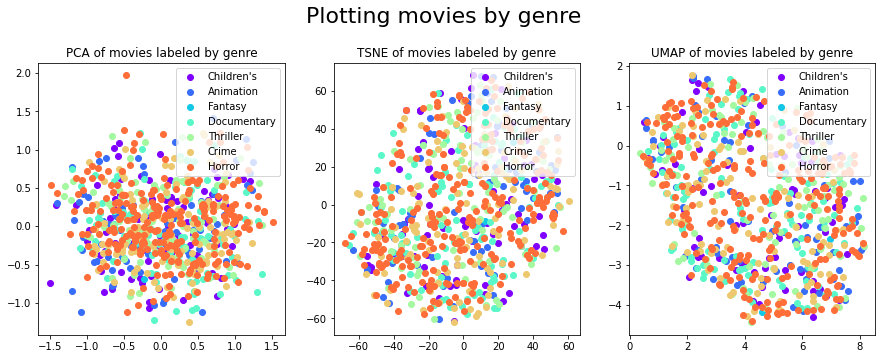

In [35]:
project_and_plot(movie_encodings[:, 1:], movie_genres_subset, title='Plotting movies by genre', elements_name='movies', label_type_name='genre', label_order=genres_subset)

### Conclusion
No clustering behaviour is observable. All classes seem to ocupy the same space.

# Plotting users by gender
In order to make the plot more visible we limit the plotted sample to 1000 random users

In [9]:
user_genders = np.array([get_or_none(lambda: users.loc[int(user[0])]['Gender']) for user in user_encodings])
genders_subset = ['M', 'F']
users_genders_subset = choose_subset(user_genders, genders_subset)

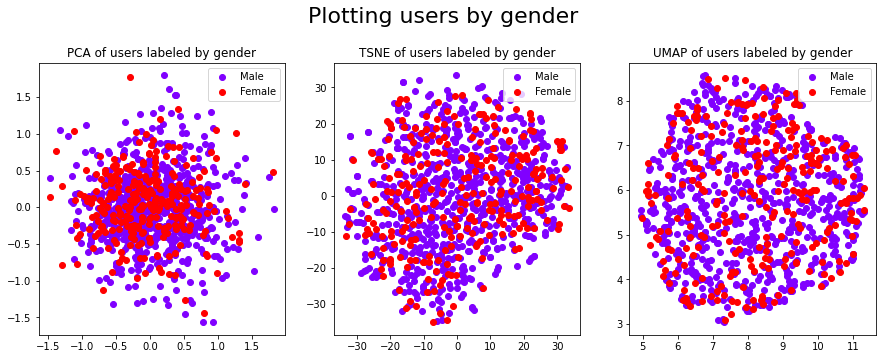

In [36]:
sample = rn.sample(range(user_encodings.shape[0]), 1000)
project_and_plot(user_encodings[sample, 1:], users_genders_subset[sample], title='Plotting users by gender', elements_name='users', label_type_name='gender', label_renaming={'M': 'Male', 'F': 'Female'})

### Conclusion
Once again no clustering is visible. We note that on the PCA representation it appears that male users have a greater spread of distribution, however, this appearance chould also be explained by there being a larger proportion of male users in the sample, thereby having more observable outliers.

# Plotting users by age
In order to make the plot comprehensible we create classes based on intervals of 10 years of age.

We limit the sample size to 500.

In [39]:
def round_age(age):
    if age == 'Unknown':
        return age
    round_down = age // 10 * 10
    round_up = round_down + 10
    return f'{round_down} - {round_up}'
user_ages = np.array([round_age(get_or_none(lambda: users.loc[int(user[0])]['Age'])) for user in user_encodings])

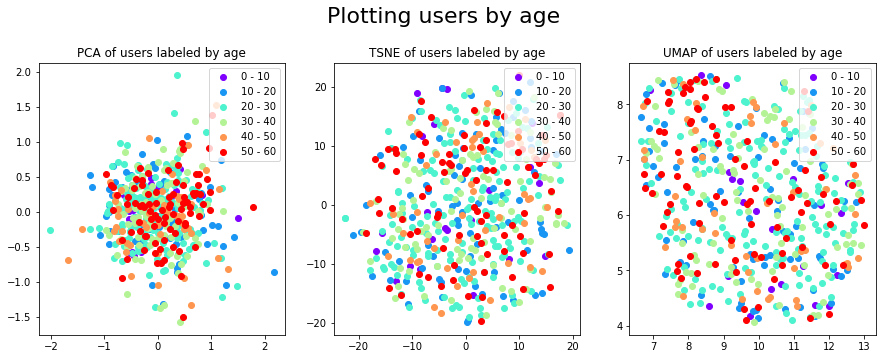

In [40]:
sample = rn.sample(range(len(user_ages)), 500)
project_and_plot(user_encodings[sample, 1:], user_ages[sample], title='Plotting users by age', elements_name='users', label_type_name='age', label_order=sorted(set(user_ages)))

### Conclusion
There are no observable clusters.

# Final Conclusions
None of our visualizations had any observable clusters. Therefore, we speculate that our Matrix Factorization model has not matured enough in order to produce correlations consistent with real-world attributes.

We also note the possibility that the attributes which were visualized may not be very significant to the predictive goal of our model, namely the ratings. For example the genre of a movie may be far less of a predictor of a user rating compared to the production quality, quality of writting, actors preformance. Similarly people may have differring tastes which are largely independent of their gender or age. A direction of further analysis would be to check whether attributes of users and movies are correlated in terms of expected rating.